# Dogs vs Cats

In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16

print(tf.__version__)
print(tf.executing_eagerly())


2.15.0
True


## Функции загрузки данных

In [2]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)

train_files = glob('../../src/cat_dogs/train/*.jpg')
test_files = glob('../../src/cat_dogs/test/*.jpg')

def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)

def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

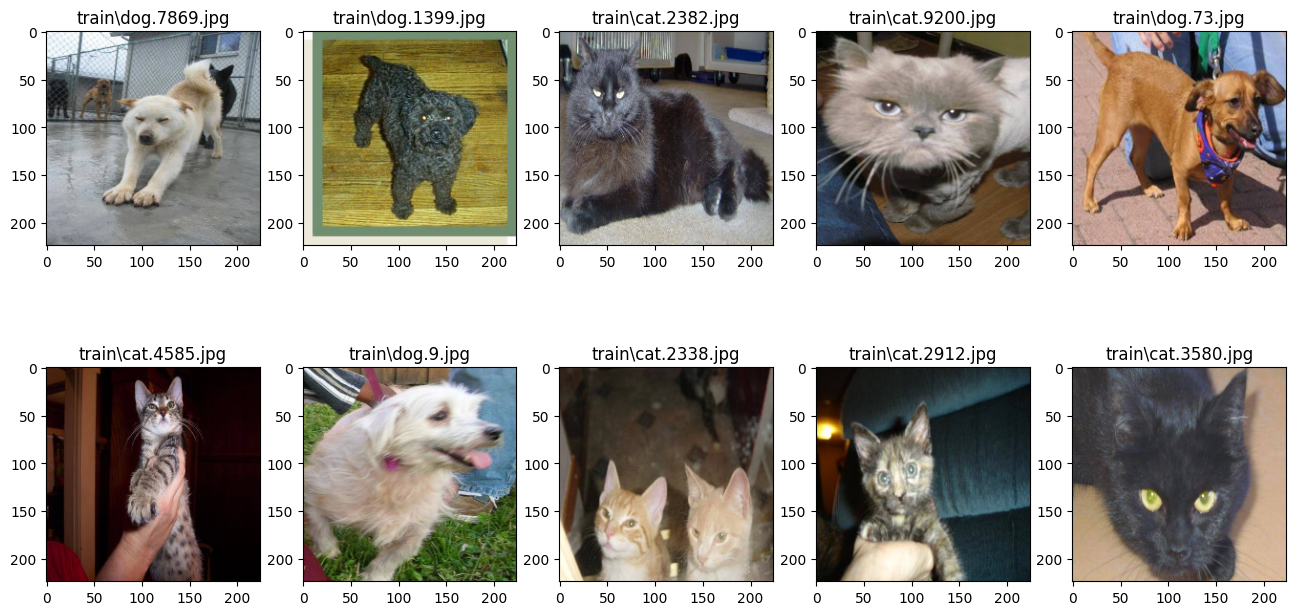

In [41]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

## Модель обучения на пред обученной модели `VGG16` с дроп аутами, и слоями свертки слоями

In [99]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Замораживаем веса базовой модели
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output

x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.10)(x)

x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.10)(x)

x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(1, 1))(x)
x = BatchNormalization()(x)
x = Dropout(0.10)(x)

x = Flatten()(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(lr=0.001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
val_samples = 3500
shuffle(train_files)
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])

model.fit(train_data,
          steps_per_epoch=10,
          epochs=100,
          validation_data=validation_data,
          callbacks=[early_stopping_callback])

Epoch 1/100
10/10 [==============================] - 205s 22s/step - loss: 0.4190 - accuracy: 0.8000 - val_loss: 0.5694 - val_accuracy: 0.4997
Epoch 2/100
10/10 [==============================] - 200s 22s/step - loss: 0.1614 - accuracy: 0.9406 - val_loss: 0.5993 - val_accuracy: 0.4960
Epoch 3/100
10/10 [==============================] - 198s 22s/step - loss: 0.1320 - accuracy: 0.9563 - val_loss: 0.4069 - val_accuracy: 0.7589
Epoch 4/100
10/10 [==============================] - 192s 21s/step - loss: 0.1694 - accuracy: 0.9344 - val_loss: 0.1983 - val_accuracy: 0.9354
Epoch 5/100
10/10 [==============================] - 200s 22s/step - loss: 0.0709 - accuracy: 0.9750 - val_loss: 0.1683 - val_accuracy: 0.9454
Epoch 6/100
10/10 [==============================] - 188s 21s/step - loss: 0.1129 - accuracy: 0.9500 - val_loss: 0.1250 - val_accuracy: 0.9766
Epoch 7/100
10/10 [==============================] - 189s 21s/step - loss: 0.1630 - accuracy: 0.9500 - val_loss: 0.1388 - val_accuracy: 0.9786

In [100]:
model.save('cats-dogs-vgg16.hdf5')

d:\avsip\code\ML\home_work_netology\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Предсказания на проверочной выборке

In [101]:
# Загрузка модели
from tensorflow.keras.models import load_model
model = load_model('cats-dogs-vgg16.hdf5')  # Загрузка обученной модели
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

12500/12500 [==============================] - 1025s 82ms/step


C:\Users\avsip\AppData\Local\Temp\ipykernel_19536\2648597163.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  subplot.set_title('%.2f %s' % (score, os.path.basename(path)))


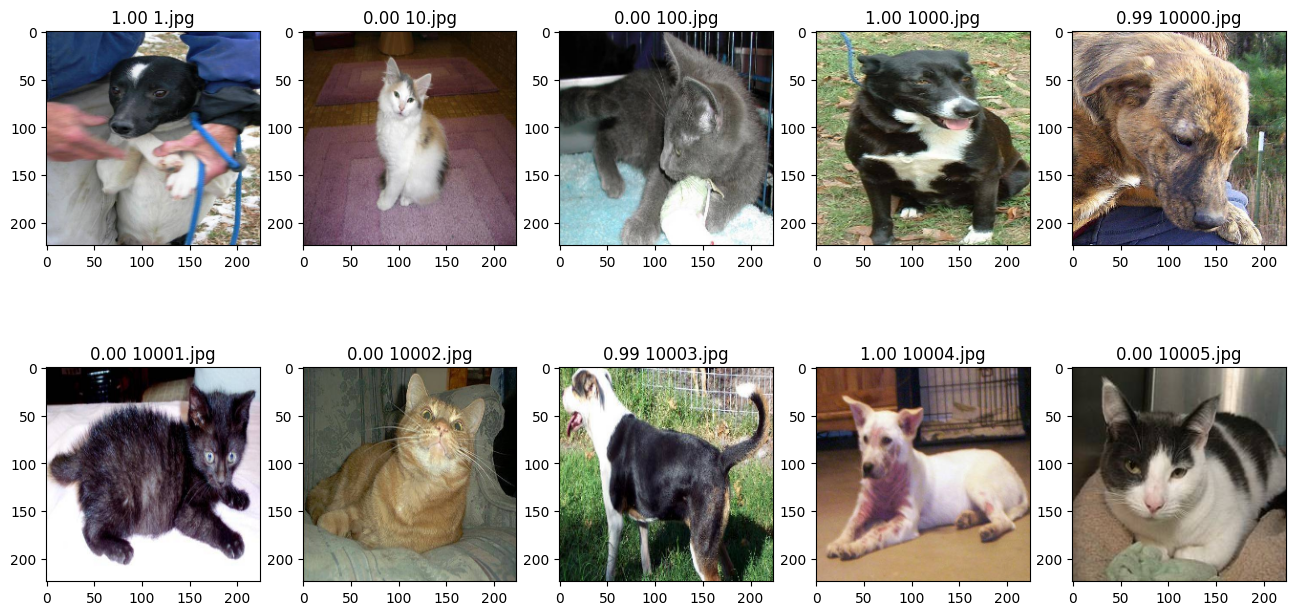

In [102]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

In [103]:
train_pred = model.predict(
    predict_generator(train_files), steps=len(train_files))

25000/25000 [==============================] - 2031s 81ms/step


## Готовим данные для отправки

In [93]:
import re

with open('sample_submission.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

C:\Users\avsip\AppData\Local\Temp\ipykernel_19536\349253541.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))


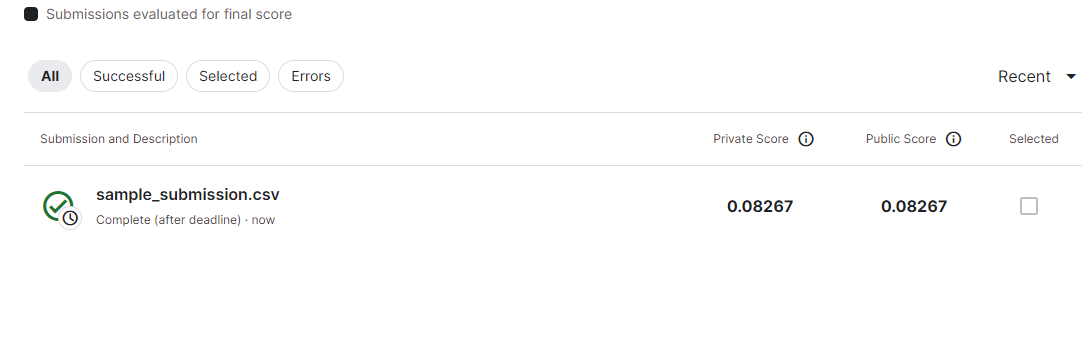

# Вывод

    + однозначно нужно железо :)
    + сформировал модель на основе `VGG16`
    + использовал следующий подход
      + Заморозил веса в момент обучения для предотвращения переобучения
      + Добавил дополнительные слои в базовую модель Слои свертки и пулинга, так же использовал нормализацию и валидацию примерно на `20-30 %` данных
    + загрузил в kaggle и получил результат
    + `Accuracy` для собак: `1`
    + `Loss` `0.08267`